In [1]:
from pathlib import Path


path = Path("CTD-data")
fname = path.joinpath("CTD-spiked-unfiltered.cnv.bz2")

In [2]:
fname

PosixPath('CTD-data/CTD-spiked-unfiltered.cnv.bz2')

In [3]:
import ctd


cast = ctd.from_cnv(fname)

### É um dataframe do pandas,

In [4]:
type(cast)

pandas.core.frame.DataFrame

In [5]:
cast.columns

Index(['scan', 'timeS', 't090C', 't190C', 'c0S/m', 'c1S/m', 'sbeox0V', 'par',
       'spar', 'ph', 'altM', 'v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7',
       'latitude', 'longitude', 'pumps', 'pla', 'sbeox0PS', 'sbeox0Mm/Kg',
       'dz/dtM', 'accM', 'flSP', 'xmiss', 'flag'],
      dtype='object')

In [6]:
down, up = cast.split()

down.head()

,scan,timeS,t090C,t190C,c0S/m,c1S/m,sbeox0V,par,spar,ph,...,longitude,pumps,pla,sbeox0PS,sbeox0Mm/Kg,dz/dtM,accM,flSP,xmiss,flag
Pressure [dbar],,,,,,,,,,,,,,,,,,,,,
6.433,1.0,0.000,26.9647,26.9314,5.821803,5.800920,2.1099,1.000000e-12,0.0000,8.575,...,-37.22588,False,26.970,69.61016,137.397,0.000,0.00,0.16484,99.2996,False
6.448,2.0,0.042,26.9644,26.9307,5.821615,5.800819,2.1148,1.000000e-12,1.9601,8.580,...,-37.22588,False,26.969,69.82216,137.817,0.351,8.43,0.16484,99.3260,False
6.433,3.0,0.083,26.9642,26.9301,5.821421,5.800727,2.1209,1.000000e-12,0.0000,8.575,...,-37.22588,False,26.969,70.08688,138.341,-0.351,-16.87,0.16606,99.3260,False
6.448,4.0,0.125,26.9639,26.9296,5.821264,5.800727,2.1270,1.000000e-12,0.0000,8.575,...,-37.22588,False,26.969,70.35184,138.865,0.351,16.86,0.16606,99.3260,False
6.433,5.0,0.167,26.9640,26.9291,5.821219,5.800634,2.1331,1.000000e-12,0.0000,8.575,...,-37.22588,False,26.969,70.61657,139.388,-0.351,-16.86,0.16606,99.3525,False


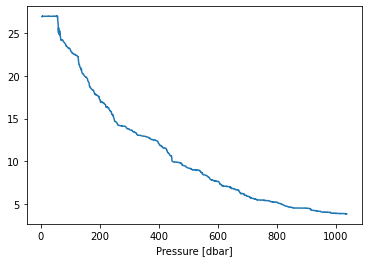

In [7]:
down["t090C"].plot()

### com uns "extras" para pre-processamento e plotagem dos dados.

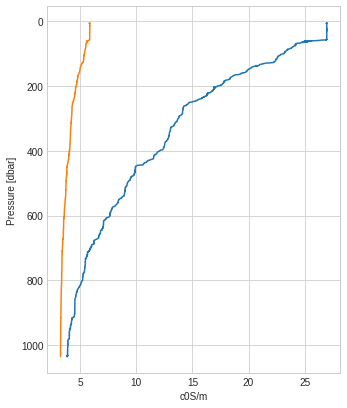

In [8]:
%matplotlib inline

from matplotlib import style

style.use("seaborn-whitegrid")


down["t090C"].plot_cast()
down["c0S/m"].plot_cast()

### Como podemos melhorar os gráficos acima?

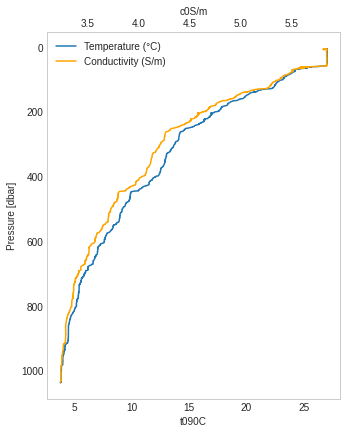

In [9]:
ax0 = down["t090C"].plot_cast(label="Temperature (°C)")

ax1 = down["c0S/m"].plot_cast(
    ax=ax0, label="Conductivity (S/m)", color="orange", secondary_y=True,
)


lines = ax0.get_lines() + ax1.get_lines()
leg = {line: line.get_label() for line in lines}
ax0.legend(leg.keys(), leg.values())
ax0.grid(False)
ax1.grid(False)

### Temos acesso aos metadados originais do arquivo CNV

In [10]:
metadata = cast._metadata

metadata.keys()

dict_keys(['header', 'config', 'names', 'skiprows', 'time', 'lon', 'lat', 'name'])

In [11]:
print(metadata["header"])

* Sea-Bird SBE 9 Data File:
* FileName = Z:\CTD_1.hex
* Software Version Seasave V 7.21h
* Temperature SN = 2317
* Conductivity SN = 4010
* Number of Bytes Per Scan = 48
* Number of Voltage Words = 5
* Number of Scans Averaged by the Deck Unit = 1
* Append System Time to Every Scan
* System UpLoad Time = Apr 01 2011 07:26:31
* NMEA Latitude = 17 58.71 S
* NMEA Longitude = 037 13.52 W
* NMEA UTC (Time) = Apr 01 2011  07:26:31
* Store Lat/Lon Data = Append to Every Scan
** Ship: RV Meteor
** Station: 1
** Operator: Ed
* System UTC = Apr 01 2011 07:26:31
*END*


## Passos para o pre-processamento:

### O primeiro passo é filtrar o *jitter* de alta frequência no sensor de pressão com um filtro de passa baixa.

Usaremos o método `.lp_filter()` para isso.

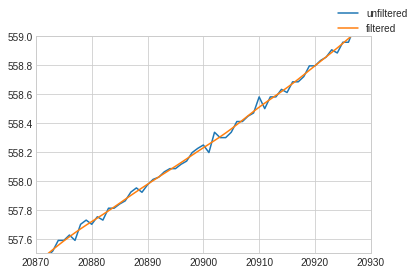

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(down.index, label="unfiltered")
ax.plot(down.lp_filter().index, label="filtered")
ax.axis([20870, 20930, 557.5, 559])
fig.legend()

Nos podemos ligar os próximos passos em "cadeia" e executá-los em um comando só:

In [13]:
down = down[["t090C", "c0S/m"]]

proc = (
    down.remove_above_water()
    .lp_filter()
    .despike(n1=2, n2=20, block=100)
    .press_check()
    .interpolate()
    .bindata(delta=1)
    .smooth(window_len=21, window="hanning")
)

proc.head()

,t090C,c0S/m
7.5,26.974138,5.845094
8.5,26.974698,5.845201
9.5,26.975249,5.845306
10.5,26.975775,5.845408
11.5,26.976265,5.845505


# EOS-80 vs TEOS-10

## CTD derive

### Agora que temos dados, filtrados, sem spikes, checados para inversão de pressão, interpolados, binados, e suavizados... Só falta computar as variáveis derivadas!

In [14]:
lon, lat = metadata["lon"], metadata["lat"]

lon, lat

(-37.22533333333333, -17.9785)

In [15]:
import gsw


p = proc.index

SP = gsw.SP_from_C(proc["c0S/m"] * 10.0, proc["t090C"], p)

SA = gsw.SA_from_SP(SP, p, lon, lat)

SR = gsw.SR_from_SP(SP)

CT = gsw.CT_from_t(SA, proc["t090C"].values, p)
z = -gsw.z_from_p(p, lat)
sigma0_CT = gsw.sigma0(SA, CT)

proc = (
    proc.assign(SP=SP)
    .assign(SA=SA)
    .assign(SR=SR)
    .assign(CT=CT)
    .assign(z=z)
    .assign(sigma0_CT=sigma0_CT)
)

In [16]:
proc

,t090C,c0S/m,SP,SA,SR,CT,z,sigma0_CT
7.5,26.974138,5.845094,37.374813,37.551223,37.551051,26.880936,7.454923,24.516828
8.5,26.974698,5.845201,37.374809,37.551219,37.551047,26.881265,8.448893,24.516719
9.5,26.975249,5.845306,37.374802,37.551213,37.551040,26.881585,9.442857,24.516612
10.5,26.975775,5.845408,37.374791,37.551203,37.551030,26.881880,10.436817,24.516509
11.5,26.976265,5.845505,37.374775,37.551187,37.551013,26.882139,11.430772,24.516413
...,...,...,...,...,...,...,...,...
1029.5,3.868543,3.238823,34.399356,34.565705,34.561564,3.792432,1020.799441,27.333365
1030.5,3.864256,3.238531,34.399867,34.566218,34.562077,3.788091,1021.788554,27.334209
1031.5,3.859281,3.238184,34.400449,34.566803,34.562662,3.783069,1022.777663,27.335177
1032.5,3.853762,3.237795,34.401090,34.567446,34.563306,3.777505,1023.766767,27.336246


Text(0.5, 1.0, 'Salinities')

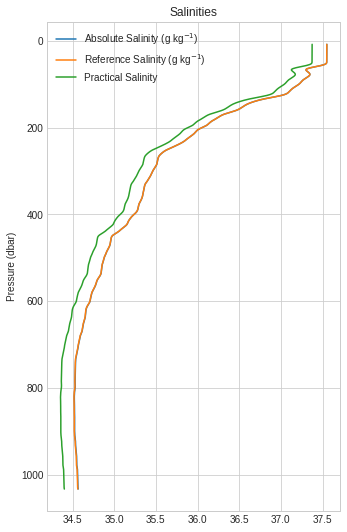

In [17]:
labels = [
    r"Absolute Salinity (g kg$^{-1}$)",
    r"Reference Salinity (g kg$^{-1}$)",
    "Practical Salinity",
]


ax = proc[["SA", "SR", "SP"]].plot_cast(figsize=(5.25, 9), label=labels,)
ax.set_ylabel("Pressure (dbar)")
ax.grid(True)
ax.legend()
ax.set_title("Salinities")

### Por puro exibicionismo vamos plotar as três variáveis principais em um único gráfico.

In [18]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

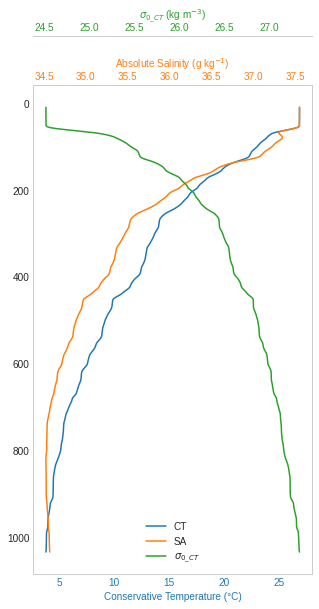

In [19]:
fig, ax0 = plt.subplots(figsize=(5, 9))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

ax0.invert_yaxis()
ax1 = ax0.twiny()
ax2 = ax0.twiny()

(l0,) = ax0.plot(proc["CT"], proc.index, color=colors[0], label="CT")
ax0.set_xlabel("Conservative Temperature (°C)")

(l1,) = ax1.plot(proc["SA"], proc.index, color=colors[1], label="SA")
ax1.set_xlabel("Absolute Salinity (g kg$^{-1}$)")

(l2,) = ax2.plot(
    proc["sigma0_CT"], proc.index, color=colors[2], label=r"$\sigma_{0\_CT}$"
)
ax2.set_xlabel(r"$\sigma_{0\_CT}$ (kg m$^{-3}$)")

make_patch_spines_invisible(ax2)
ax2.spines["top"].set_position(("axes", 1.1))
ax2.spines["top"].set_visible(True)

ax0.xaxis.label.set_color(l0.get_color())
ax1.xaxis.label.set_color(l1.get_color())
ax2.xaxis.label.set_color(l2.get_color())

ax0.tick_params(axis="x", colors=l0.get_color())
ax1.tick_params(axis="x", colors=l1.get_color())
ax2.tick_params(axis="x", colors=l2.get_color())

lines = ax0.get_lines() + ax1.get_lines() + ax2.get_lines()
leg = {line: line.get_label() for line in lines}

ax0.legend(leg.keys(), leg.values(), loc=8)

ax0.grid(False)
ax1.grid(False)
ax2.grid(False)